# 05 - Interprétation du modèle LGBM

Objectif : fournir une interprétation **globale** et **locale** des modèles, avec un focus sur LightGBM.

Méthodes utilisées :
- **Importance globale** : gain et split LightGBM
- **Importance par permutation** : impact de chaque feature sur l'AUC
- **Partial Dependence Plots** : relation entre features et prédictions
- **Analyse locale** : contribution des features pour un client spécifique

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from src.mlflow_config import configure_mlflow
import mlflow
import mlflow.lightgbm
import mlflow.sklearn
import mlflow.pyfunc

RANDOM_STATE = 42
sns.set_style("whitegrid")

In [2]:
DATA_PATH = "../data/processed/"
TRAIN_FILE = "features_train.csv"
TEST_FILE = "features_test.csv"

X_train = pd.read_csv(DATA_PATH + TRAIN_FILE)
y_train = X_train.pop("TARGET")

X_test = pd.read_csv(DATA_PATH + TEST_FILE)
y_test = X_test.pop("TARGET")

# Garder une copie AVANT sanitization pour le modèle de régression
X_train_reg = X_train.copy()
X_test_reg = X_test.copy()

def sanitize_feature_names(columns):
    cleaned = (
        pd.Series(columns)
        .astype(str)
        .str.replace(r"[\"\\{}\[\]:,]", "_", regex=True)
        .str.replace(r"\s+", "_", regex=True)
    )
    # rendre uniques si collisions
    if cleaned.duplicated().any():
        cleaned = cleaned + "_" + cleaned.groupby(cleaned).cumcount().astype(str)
    return cleaned.tolist()

# Nettoyage : suppression colonnes 100% NaN + imputation médiane
def clean_and_impute(train_df, test_df=None):
    empty_cols_train = train_df.columns[train_df.isna().all()].tolist()
    empty_cols_test = []
    if test_df is not None:
        empty_cols_test = test_df.columns[test_df.isna().all()].tolist()
    cols_to_drop = set(empty_cols_train) | set(empty_cols_test)
    if cols_to_drop:
        train_df = train_df.drop(columns=list(cols_to_drop))
        if test_df is not None:
            test_df = test_df.drop(columns=list(cols_to_drop))
    imputer = SimpleImputer(strategy="median")
    train_arr = imputer.fit_transform(train_df)
    train_df = pd.DataFrame(train_arr, columns=train_df.columns)
    if test_df is not None:
        test_arr = imputer.transform(test_df)
        test_df = pd.DataFrame(test_arr, columns=test_df.columns)
    return train_df, test_df

X_train, X_test = clean_and_impute(X_train, X_test)
X_train_reg, X_test_reg = clean_and_impute(X_train_reg, X_test_reg)

# Nettoyer les noms de features pour LightGBM
clean_names = sanitize_feature_names(X_train.columns)
X_train.columns = clean_names
X_test.columns = clean_names

# X_train_reg et X_test_reg gardent les noms originaux (pour le modèle de régression)

print("✓ Données chargées et nettoyées")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape}")

✓ Données chargées et nettoyées
  X_train: (10000, 724) | y_train: (10000,)
  X_test:  (10000, 724) | y_test:  (10000,)


In [3]:
# Split pour validation uniquement
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

# Split identique pour les données de régression (avec noms originaux)
X_tr_reg, X_val_reg, y_tr_reg, y_val_reg = train_test_split(
    X_train_reg, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

mlflow = configure_mlflow(autolog=False)

LGBM_MODEL_NAME = "LightGBM"
REG_MODEL_NAME = "regression"

def load_model_from_registry(model_name):
    last_error = None
    for loader in (mlflow.lightgbm.load_model, mlflow.sklearn.load_model, mlflow.pyfunc.load_model):
        try:
            return loader(f"models:/{model_name}/latest")
        except Exception as exc:
            last_error = exc
    raise RuntimeError(f"Impossible de charger le modèle '{model_name}'.") from last_error

lgbm_model = load_model_from_registry(LGBM_MODEL_NAME)
reg_model = load_model_from_registry(REG_MODEL_NAME)

# Modèle utilisé pour l'interprétation (LightGBM)
model = lgbm_model

# Fonction wrapper pour predict_proba (compatible lgb.Booster et sklearn)
def predict_proba_wrapper(model, X):
    """Wrapper pour gérer à la fois lgb.Booster et sklearn-like models."""
    if hasattr(model, "predict_proba"):
        # Modèle sklearn-like
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "predict"):
        # lgb.Booster - predict() retourne directement les probabilités
        predictions = model.predict(X)
        # Si c'est un array 1D, c'est déjà les probas de la classe positive
        if len(predictions.shape) == 1:
            return predictions
        # Si c'est 2D, prendre la colonne 1
        return predictions[:, 1]
    else:
        raise RuntimeError("Le modèle ne supporte ni predict_proba ni predict")

y_val_proba = predict_proba_wrapper(model, X_val)
auc = roc_auc_score(y_val, y_val_proba)

print(f"✓ Modèle MLflow chargé | Type: {type(model).__name__}")
print(f"  AUC validation: {auc:.4f}")

✓ Modèle MLflow chargé | Type: Booster
  AUC validation: 0.7519


,feature,importance_gain
33,EXT_SOURCE_3,11561.128334
32,EXT_SOURCE_2,8336.417473
31,EXT_SOURCE_1,4450.903070
243,PAYMENT_RATE,4304.280479
13,DAYS_ID_PUBLISH,4146.748919
11,DAYS_EMPLOYED,2567.204699
12,DAYS_REGISTRATION,2441.321718
242,ANNUITY_INCOME_PERC,2178.935495
239,DAYS_EMPLOYED_PERC,2125.762104
7,AMT_ANNUITY,1994.866804


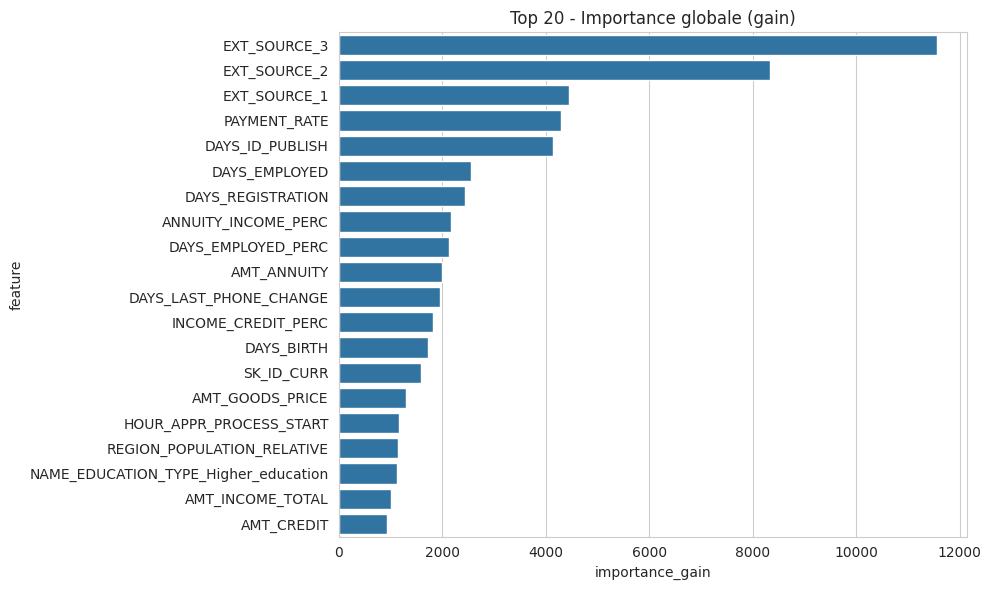

In [4]:
# Importance globale (gain LightGBM)
# LightGBM Booster expose feature_importance() et feature_name()
feature_names = model.feature_name()
if len(feature_names) != X_train.shape[1]:
    feature_names = list(X_train.columns)
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance_gain": model.feature_importance(importance_type="gain")
}).sort_values("importance_gain", ascending=False)

display(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x="importance_gain", y="feature")
plt.title("Top 20 - Importance globale (gain)")
plt.tight_layout()
plt.show()

,feature,importance
33,EXT_SOURCE_3,0.070811
32,EXT_SOURCE_2,0.053781
243,PAYMENT_RATE,0.016741
11,DAYS_EMPLOYED,0.009783
13,DAYS_ID_PUBLISH,0.005539
12,DAYS_REGISTRATION,0.005289
81,DAYS_LAST_PHONE_CHANGE,0.003847
31,EXT_SOURCE_1,0.003349
242,ANNUITY_INCOME_PERC,0.003103
125,NAME_EDUCATION_TYPE_Higher_education,0.002870


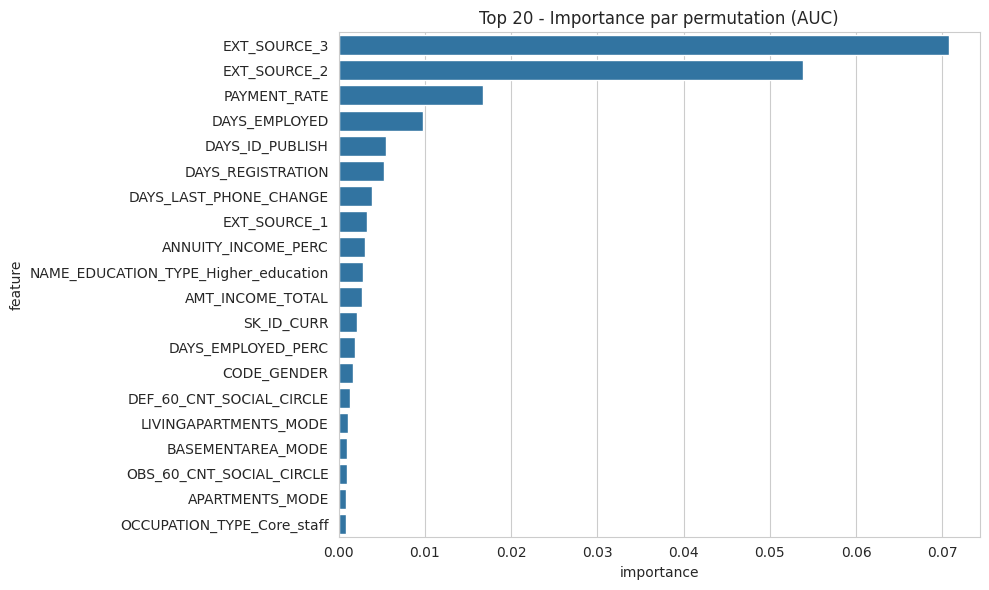

In [5]:
# Importance par permutation (sur la validation)
# permutation_importance exige un estimator sklearn-like avec fit()
from sklearn.base import BaseEstimator, ClassifierMixin

class BoosterSklearnWrapper(ClassifierMixin, BaseEstimator):
    def __init__(self, booster):
        self.booster = booster
        self.classes_ = np.array([0, 1])

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns) if hasattr(X, "columns") else None
        return self

    def predict_proba(self, X):
        proba = self.booster.predict(X)
        if proba.ndim == 1:
            return np.vstack([1 - proba, proba]).T
        return proba

wrapper = BoosterSklearnWrapper(model)
perm = permutation_importance(
    wrapper, X_val, y_val, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1, scoring="roc_auc"
)
perm_df = pd.DataFrame({
    "feature": list(X_val.columns),
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

display(perm_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df.head(20), x="importance", y="feature")
plt.title("Top 20 - Importance par permutation (AUC)")
plt.tight_layout()
plt.show()

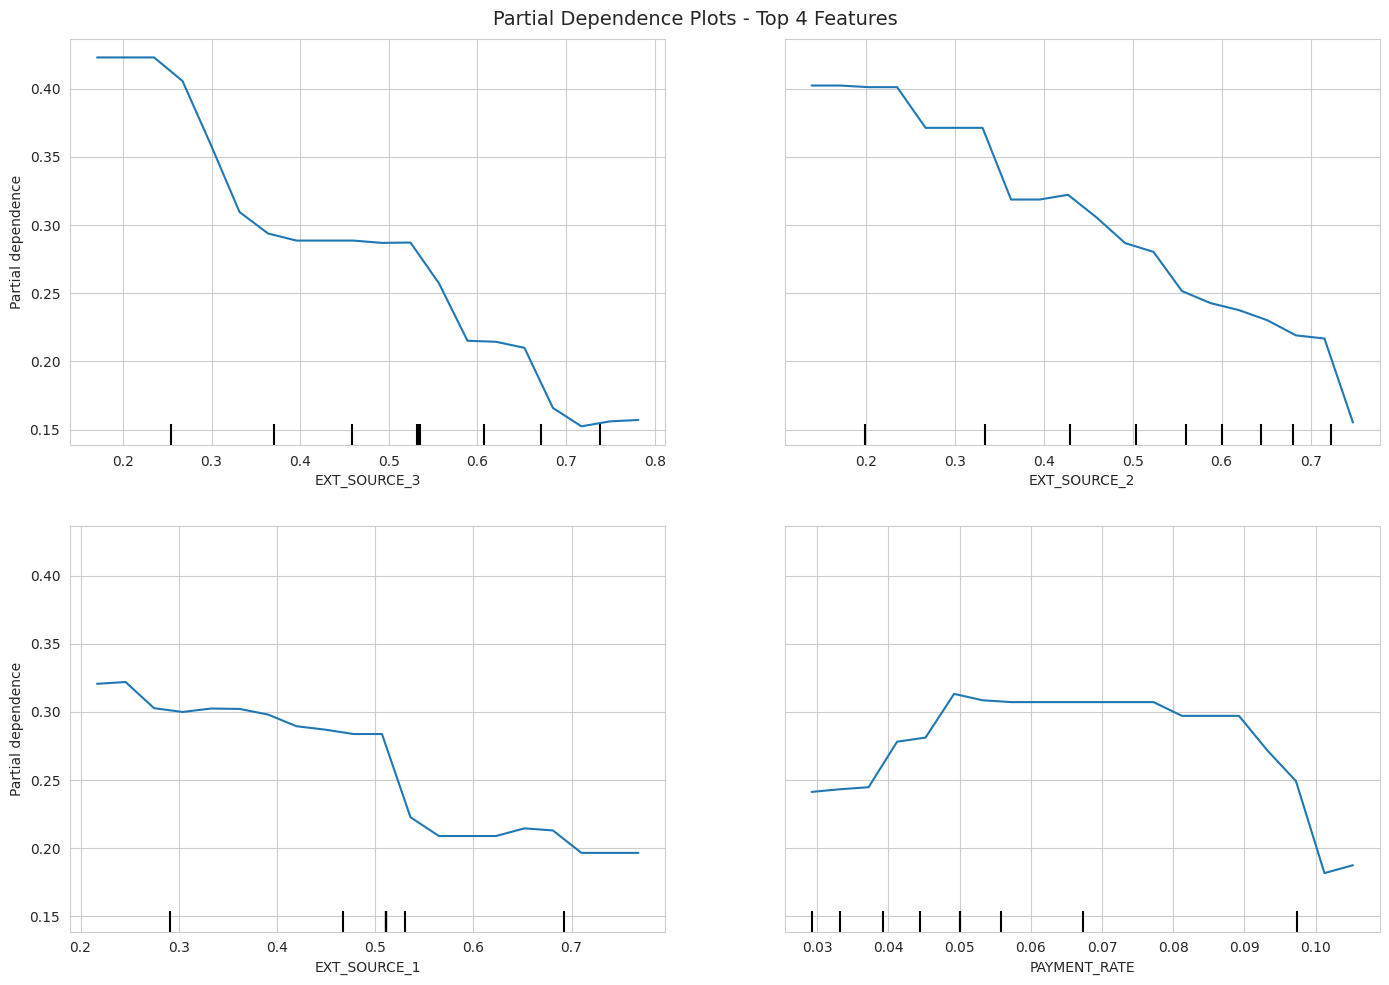

PDP calculés pour: EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1, PAYMENT_RATE


In [6]:
# Partial Dependence Plots (PDP) - Top 4 features
top_features = importance_df.head(4)["feature"].tolist()

# Utiliser le wrapper sklearn-like pour LightGBM Booster
wrapper.fit(X_val, y_val)

fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(
    wrapper,
    X_val,
    features=top_features,
    ax=ax,
    n_cols=2,
    grid_resolution=20
 )
plt.suptitle("Partial Dependence Plots - Top 4 Features", fontsize=14)
plt.tight_layout()
plt.show()

print(f"PDP calculés pour: {', '.join(top_features)}")

Client index 0 | Probabilité de défaut: 0.4172
Valeur cible réelle: 0.0

Top 10 features les plus influentes pour ce client:


,feature,valeur_client,moyenne_dataset,ecart_normalise,importance_gain,impact_potentiel
243,PAYMENT_RATE,0.029395,0.053477,-1.058328,4304.280479,4555.341639
33,EXT_SOURCE_3,0.461482,0.515701,-0.307138,11561.128334,3550.864261
13,DAYS_ID_PUBLISH,-4065.000000,-2971.298500,-0.725994,4146.748919,3010.516776
12,DAYS_REGISTRATION,-913.000000,-4854.288000,1.122240,2441.321718,2739.747929
0,SK_ID_CURR,110916.000000,105767.572000,1.535343,1588.196901,2438.426445
10,DAYS_BIRTH,-21221.000000,-15859.059500,-1.212904,1731.432922,2100.061761
240,INCOME_CREDIT_PERC,0.136393,0.402524,-0.763911,1827.355900,1395.937350
81,DAYS_LAST_PHONE_CHANGE,-465.000000,-955.922000,0.600561,1954.928787,1174.054498
32,EXT_SOURCE_2,0.484678,0.509815,-0.130884,8336.417473,1091.100315
14,OWN_CAR_AGE,1.000000,9.998500,-1.266770,717.977108,909.511652


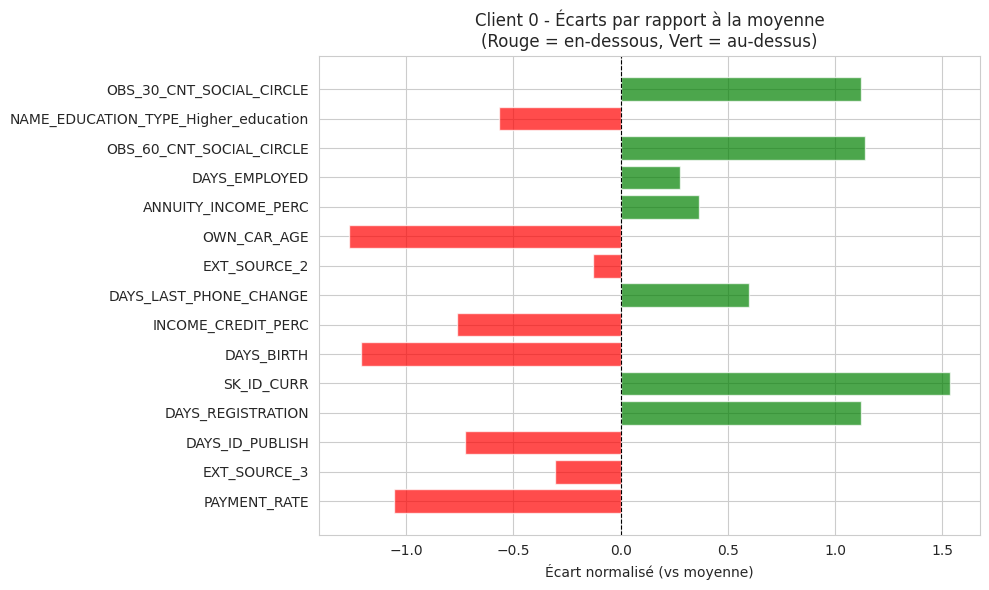

In [7]:
# Analyse locale d'un client - Contribution des features
CLIENT_INDEX = 0  # Modifier si besoin
client_row = X_val.iloc[[CLIENT_INDEX]]

# Prédiction pour ce client (utiliser le wrapper)
proba = predict_proba_wrapper(model, client_row)[0]
print(f"Client index {CLIENT_INDEX} | Probabilité de défaut: {proba:.4f}")
print(f"Valeur cible réelle: {y_val.iloc[CLIENT_INDEX]}")

# Analyse des valeurs de features pour ce client vs moyennes
client_df = pd.DataFrame({
    "feature": client_row.columns,
    "valeur_client": client_row.values[0],
    "moyenne_dataset": X_val.mean().values,
    "ecart_std": X_val.std().values
})

# Calculer l'écart normalisé
client_df["ecart_normalise"] = (
    (client_df["valeur_client"] - client_df["moyenne_dataset"]) / client_df["ecart_std"]
)

# Joindre avec l'importance des features
client_df = client_df.merge(
    importance_df[["feature", "importance_gain"]], 
    on="feature", 
    how="left"
)

# Trier par impact potentiel (importance × écart)
client_df["impact_potentiel"] = (
    client_df["importance_gain"] * client_df["ecart_normalise"].abs()
)
client_df = client_df.sort_values("impact_potentiel", ascending=False)

print("\nTop 10 features les plus influentes pour ce client:")
display(client_df.head(10)[
    ["feature", "valeur_client", "moyenne_dataset", "ecart_normalise", "importance_gain", "impact_potentiel"]
])

# Visualisation
plt.figure(figsize=(10, 6))
top_impact = client_df.head(15)
colors = ['red' if x < 0 else 'green' for x in top_impact["ecart_normalise"]]
plt.barh(range(len(top_impact)), top_impact["ecart_normalise"], color=colors, alpha=0.7)
plt.yticks(range(len(top_impact)), top_impact["feature"])
plt.xlabel("Écart normalisé (vs moyenne)")
plt.title(f"Client {CLIENT_INDEX} - Écarts par rapport à la moyenne\n(Rouge = en-dessous, Vert = au-dessus)")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# 06 - Interprétation du modèle de Régression

Même analyse pour le modèle de régression : importance des features, PDP, et analyse locale.

In [8]:
# Changement de modèle : utiliser le modèle de Régression (qui est en réalité une LogisticRegression - classifieur)
model_reg = reg_model

# Évaluation du modèle (utiliser X_val_reg avec noms originaux)
y_val_pred_reg = model_reg.predict_proba(X_val_reg)[:, 1]

# Adapter le wrapper pour LogisticRegression (compatible avec PartialDependenceDisplay)
from sklearn.base import ClassifierMixin

class LogisticSklearnWrapper(ClassifierMixin, BaseEstimator):
    def __init__(self, classifier):
        self.classifier = classifier
        self.classes_ = np.array([0, 1])
    
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns) if hasattr(X, "columns") else None
        return self
    
    def predict_proba(self, X):
        return self.classifier.predict_proba(X)

wrapper_reg = LogisticSklearnWrapper(model_reg)

# Évaluer avec les mêmes métriques que LightGBM (puisque c'est aussi un classifieur)
from sklearn.metrics import accuracy_score
auc_reg = roc_auc_score(y_val_reg, y_val_pred_reg)
acc_reg = accuracy_score(y_val_reg, model_reg.predict(X_val_reg))

print(f"✓ Modèle Régression chargé | Type: {type(model_reg).__name__}")
print(f"  Note: C'est en réalité une LogisticRegression (classifieur binaire), pas une vraie régression")
print(f"  AUC validation: {auc_reg:.4f}")
print(f"  Accuracy validation: {acc_reg:.4f}")

✓ Modèle Régression chargé | Type: LogisticRegression
  Note: C'est en réalité une LogisticRegression (classifieur binaire), pas une vraie régression
  AUC validation: 0.4995
  Accuracy validation: 0.9215



📊 Coefficients standardisés - LogisticRegression
   Features avec importance > 0: 573 / 724
   Max importance: 851380334.970249


,feature,importance
606,INSTAL_PAYMENT_DIFF_VAR,8.513803e+08
632,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,5.871043e+06
672,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,1.079594e+06
677,CC_AMT_RECIVABLE_VAR,8.771825e+05
682,CC_AMT_TOTAL_RECEIVABLE_VAR,8.771825e+05
642,CC_AMT_DRAWINGS_CURRENT_VAR,8.560059e+05
667,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,7.764642e+05
627,CC_AMT_BALANCE_VAR,7.181227e+05
662,CC_AMT_PAYMENT_CURRENT_VAR,6.468800e+05
652,CC_AMT_DRAWINGS_POS_CURRENT_VAR,4.982372e+05


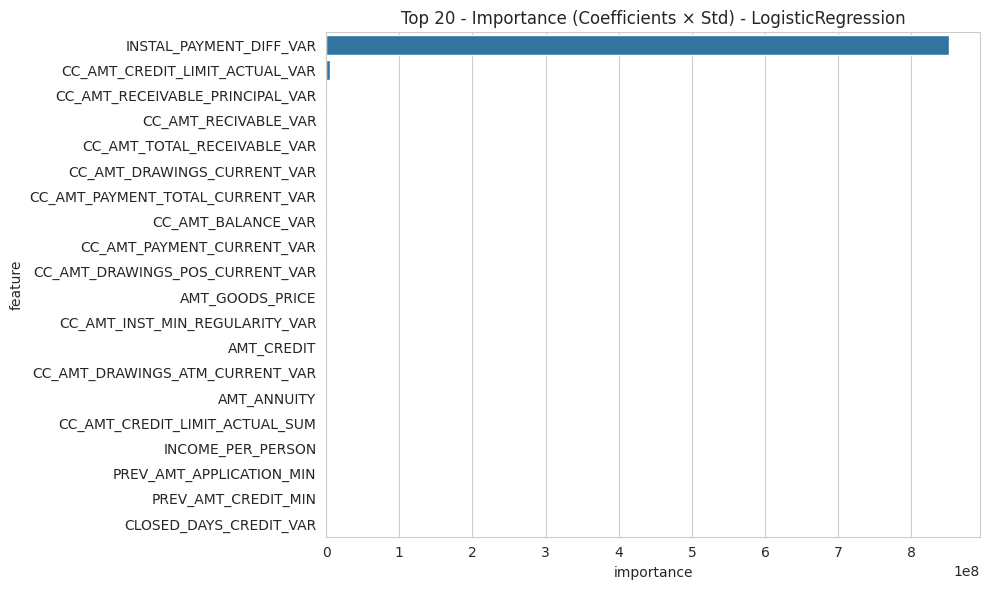

In [9]:
# Importance globale du modèle de Régression (LogisticRegression)
# Pour LogisticRegression, on utilise les coefficients standardisés
# Importance = |coef| * std(feature) pour être comparable aux autres méthodes

feature_names_reg = list(X_val_reg.columns)
feature_std = X_val_reg.std().values

# Coefficients standardisés = |coef| * std(feature)
if hasattr(model_reg, 'coef_'):
    coefficients_std = np.abs(model_reg.coef_[0]) * feature_std
else:
    coefficients_std = np.zeros(len(feature_names_reg))

importance_df_reg = pd.DataFrame({
    "feature": feature_names_reg,
    "importance": coefficients_std
}).sort_values("importance", ascending=False)

print(f"\n📊 Coefficients standardisés - LogisticRegression")
print(f"   Features avec importance > 0: {(coefficients_std > 0).sum()} / {len(coefficients_std)}")
print(f"   Max importance: {coefficients_std.max():.6f}")

display(importance_df_reg.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_reg.head(20), x="importance", y="feature")
plt.title("Top 20 - Importance (Coefficients × Std) - LogisticRegression")
plt.tight_layout()
plt.show()

In [ ]:
# Importance par permutation - Modèle LogisticRegression (validation alternative)
wrapper_reg.fit(X_val_reg, y_val_reg)

perm_reg = permutation_importance(
    wrapper_reg, X_val_reg, y_val_reg, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1, scoring="roc_auc"
)
perm_df_reg = pd.DataFrame({
    "feature": list(X_val_reg.columns),
    "importance": perm_reg.importances_mean
}).sort_values("importance", ascending=False)

print(f"\n📊 Permutation Importance (alternative) - LogisticRegression")
print(f"   Max: {perm_reg.importances_mean.max():.6f}")
print(f"   Note: Valeurs petites = peu d'impact sur AUC quand mélangées")

display(perm_df_reg.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df_reg.head(20), x="importance", y="feature")
plt.title("Top 20 - Importance par permutation (AUC) - LogisticRegression")
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (52993562.py, line 20)

In [ ]:
# Partial Dependence Plots (PDP) - Top 4 features - Régression
top_features_reg = importance_df_reg.head(4)["feature"].tolist()

fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(
    wrapper_reg,
    X_val_reg,
    features=top_features_reg,
    ax=ax,
    n_cols=2,
    grid_resolution=20
)
plt.suptitle("Partial Dependence Plots - Top 4 Features - Régression", fontsize=14)
plt.tight_layout()
plt.show()

print(f"PDP calculés pour (Régression): {', '.join(top_features_reg)}")

In [ ]:
# Analyse locale d'un client - LogisticRegression
CLIENT_INDEX_REG = 0  # Modifier si besoin
client_row_reg = X_val_reg.iloc[[CLIENT_INDEX_REG]]

# Prédiction pour ce client (probabilité de défaut)
proba_reg = model_reg.predict_proba(client_row_reg)[0, 1]
print(f"Client index {CLIENT_INDEX_REG} | Probabilité de défaut: {proba_reg:.4f}")
print(f"Valeur cible réelle: {y_val_reg.iloc[CLIENT_INDEX_REG]}")

# Analyse des valeurs de features pour ce client vs moyennes
client_df_reg = pd.DataFrame({
    "feature": client_row_reg.columns,
    "valeur_client": client_row_reg.values[0],
    "moyenne_dataset": X_val_reg.mean().values,
    "ecart_std": X_val_reg.std().values
})

# Calculer l'écart normalisé
client_df_reg["ecart_normalise"] = (
    (client_df_reg["valeur_client"] - client_df_reg["moyenne_dataset"]) / client_df_reg["ecart_std"]
)

# Joindre avec l'importance des features
client_df_reg = client_df_reg.merge(
    importance_df_reg[["feature", "importance"]], 
    on="feature", 
    how="left"
)

# Trier par impact potentiel (importance × écart)
client_df_reg["impact_potentiel"] = (
    client_df_reg["importance"] * client_df_reg["ecart_normalise"].abs()
)
client_df_reg = client_df_reg.sort_values("impact_potentiel", ascending=False)

print("\nTop 10 features les plus influentes pour ce client (LogisticRegression):")
display(client_df_reg.head(10)[
    ["feature", "valeur_client", "moyenne_dataset", "ecart_normalise", "importance", "impact_potentiel"]
])

# Visualisation
plt.figure(figsize=(10, 6))
top_impact_reg = client_df_reg.head(15)
colors = ['red' if x < 0 else 'green' for x in top_impact_reg["ecart_normalise"]]
plt.barh(range(len(top_impact_reg)), top_impact_reg["ecart_normalise"], color=colors, alpha=0.7)
plt.yticks(range(len(top_impact_reg)), top_impact_reg["feature"])
plt.xlabel("Écart normalisé (vs moyenne)")
plt.title(f"Client {CLIENT_INDEX_REG} - Écarts par rapport à la moyenne (LogisticRegression)\n(Rouge = en-dessous, Vert = au-dessus)")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()